In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from scipy.ndimage import distance_transform_edt
import kagglehub

path = kagglehub.dataset_download(
    "andrewmvd/drive-digital-retinal-images-for-vessel-extraction"
)

image_dir = f"{path}/DRIVE/training/images"
gt_dir    = f"{path}/DRIVE/training/1st_manual"
fov_dir   = f"{path}/DRIVE/training/mask"

img_files = sorted(os.listdir(image_dir))
gt_files  = sorted(os.listdir(gt_dir))
fov_files = sorted(os.listdir(fov_dir))

print(len(img_files), "images loaded")


20 images loaded


In [18]:
def sensitivity(pred, gt):
    tp = np.sum((pred==1) & (gt==1))
    fn = np.sum((pred==0) & (gt==1))
    return tp/(tp+fn+1e-8)

def dice(pred, gt):
    tp = np.sum((pred==1) & (gt==1))
    fp = np.sum((pred==1) & (gt==0))
    fn = np.sum((pred==0) & (gt==1))
    return 2*tp/(2*tp+fp+fn+1e-8)

def extract_thin_vessels(gt):
    dist = distance_transform_edt(gt)
    thin = ((gt==1) & (dist<=2)).astype(np.uint8)
    return thin


In [19]:
def preprocess(img):
    g = img[:,:,1]  # green channel
    
    # CLAHE improves contrast for thin vessels
    clahe = cv2.createCLAHE(2.0, (8,8))
    g = clahe.apply(g)
    
    return g


In [20]:
windows = [15, 25, 35]
k_niblack = [-0.2, -0.1, 0.1]
k_sauvola = [0.2, 0.3, 0.4]
R_value = 60


In [21]:
best_niblack = (0, None)

for w in windows:
    for k in k_niblack:
        thin_scores = []
        overall_scores = []

        for i in range(len(img_files)):
            img = cv2.imread(os.path.join(image_dir,img_files[i]))
            gt  = cv2.imread(os.path.join(gt_dir,gt_files[i]),0)
            fov = cv2.imread(os.path.join(fov_dir,fov_files[i]),0)

            img = preprocess(img)

            gt  = (gt>0).astype(np.uint8)
            fov = (fov>0).astype(np.uint8)

            thr = threshold_niblack(img, window_size=w, k=k)
            pred = (img < thr).astype(np.uint8) * fov
            gt *= fov

            thin_scores.append(sensitivity(pred, extract_thin_vessels(gt)))
            overall_scores.append(dice(pred, gt))

        score = np.mean(thin_scores)

        if score > best_niblack[0]:
            best_niblack = (score, w, k, np.mean(overall_scores))

        print(f"Niblack w={w}, k={k} → ThinSens={score:.3f}")

print("\nBEST NIBLACK:", best_niblack)


Niblack w=15, k=-0.2 → ThinSens=0.877
Niblack w=15, k=-0.1 → ThinSens=0.852
Niblack w=15, k=0.1 → ThinSens=0.797
Niblack w=25, k=-0.2 → ThinSens=0.888
Niblack w=25, k=-0.1 → ThinSens=0.864
Niblack w=25, k=0.1 → ThinSens=0.810
Niblack w=35, k=-0.2 → ThinSens=0.883
Niblack w=35, k=-0.1 → ThinSens=0.857
Niblack w=35, k=0.1 → ThinSens=0.803

BEST NIBLACK: (np.float64(0.8878454244778732), 25, -0.2, np.float64(0.35268660171459865))


In [22]:
best_sauvola = (0, None)

for w in windows:
    for k in k_sauvola:
        thin_scores = []
        overall_scores = []

        for i in range(len(img_files)):
            img = cv2.imread(os.path.join(image_dir,img_files[i]))
            gt  = cv2.imread(os.path.join(gt_dir,gt_files[i]),0)
            fov = cv2.imread(os.path.join(fov_dir,fov_files[i]),0)

            img = preprocess(img)

            gt  = (gt>0).astype(np.uint8)
            fov = (fov>0).astype(np.uint8)

            thr = threshold_sauvola(img, window_size=w, k=k, r=R_value)
            pred = (img < thr).astype(np.uint8) * fov
            gt *= fov

            thin_scores.append(sensitivity(pred, extract_thin_vessels(gt)))
            overall_scores.append(dice(pred, gt))

        score = np.mean(thin_scores)

        if score > best_sauvola[0]:
            best_sauvola = (score, w, k, np.mean(overall_scores))

        print(f"Sauvola w={w}, k={k} → ThinSens={score:.3f}")

print("\nBEST SAUVOLA:", best_sauvola)


Sauvola w=15, k=0.2 → ThinSens=0.473
Sauvola w=15, k=0.3 → ThinSens=0.318
Sauvola w=15, k=0.4 → ThinSens=0.210
Sauvola w=25, k=0.2 → ThinSens=0.527
Sauvola w=25, k=0.3 → ThinSens=0.373
Sauvola w=25, k=0.4 → ThinSens=0.256
Sauvola w=35, k=0.2 → ThinSens=0.548
Sauvola w=35, k=0.3 → ThinSens=0.400
Sauvola w=35, k=0.4 → ThinSens=0.280

BEST SAUVOLA: (np.float64(0.5478378492091072), 35, 0.2, np.float64(0.6396279453738265))


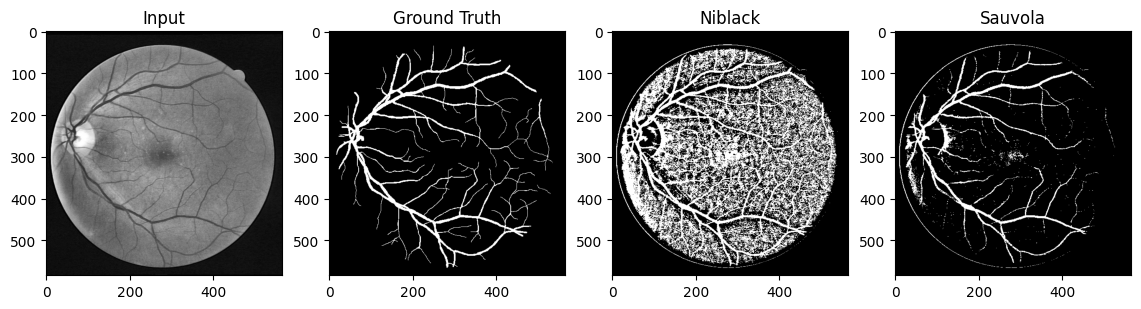

In [23]:
_, wn, kn, _ = best_niblack
_, ws, ks, _ = best_sauvola

img = cv2.imread(os.path.join(image_dir,img_files[0]))
gt  = cv2.imread(os.path.join(gt_dir,gt_files[0]),0)
fov = cv2.imread(os.path.join(fov_dir,fov_files[0]),0)

img_p = preprocess(img)
gt = (gt>0).astype(np.uint8)
fov = (fov>0).astype(np.uint8)

thr_n = threshold_niblack(img_p, window_size=wn, k=kn)
thr_s = threshold_sauvola(img_p, window_size=ws, k=ks, r=R_value)

nb = (img_p<thr_n).astype(np.uint8)*fov
sv = (img_p<thr_s).astype(np.uint8)*fov

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.imshow(img_p,cmap='gray'); plt.title("Input")

plt.subplot(1,4,2)
plt.imshow(gt,cmap='gray'); plt.title("Ground Truth")

plt.subplot(1,4,3)
plt.imshow(nb,cmap='gray'); plt.title("Niblack")

plt.subplot(1,4,4)
plt.imshow(sv,cmap='gray'); plt.title("Sauvola")

plt.show()


Niblack and Sauvola thresholding behaved very differently for retinal vessel detection. Niblack was more sensitive and detected most thin vessels, but it also classified background noise as vessels, resulting in many false positives. Sauvola was more conservative, producing cleaner vessel maps with fewer false detections, but it missed many thin vessels, leading to lower sensitivity.

In simple terms, Niblack detects more vessels but adds noise, while Sauvola produces cleaner results but misses faint vessels.